# Inference and Gender Gaps

Allen Downey

[MIT License](https://en.wikipedia.org/wiki/MIT_License)

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils import decorate

aimb_light_gray = '#F3F4F3'
aimb_medium_gray = '#767676'

plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = [6, 4]

#plt.rcParams['axes.facecolor'] = aimb_light_gray
plt.rcParams['axes.edgecolor'] = aimb_medium_gray
#plt.rcParams['text.color'] = aimb_medium_gray
#plt.rcParams['axes.labelcolor'] = aimb_medium_gray
#plt.rcParams['xtick.color'] = aimb_medium_gray
#plt.rcParams['ytick.color'] = aimb_medium_gray
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['axes.titlesize'] = 11

In [2]:
gss = pd.read_hdf('gss_feminism_2022.hdf', key='gss')

Here are the 10 `fe` variables and the text of the questions.

`fechld` 

> A. A working mother can establish just as warm and secure a relationship with her children as a mother who does not work.

`fefam`

> D. It is much better for everyone involved if the man is the achiever outside the home and the woman takes care of the home and family.

`fehelp`

> B. It is more important for a wife to help her husband's career than to have one herself.

`fehire`

> Because of past discrimination, employers should make special efforts to hire and promote qualified women.

`fehome`

> Women should take care of running their homes and leave running the country up to men.

`fejobaff`

> Some people say that because of past discrimination, women should be given preference in hiring and promotion. Others say that such preference in hiring and promotion of women is wrong because it discriminates against men. What about your opinion - are you for or against preferential hiring and promotion of women?
IF FOR:Do you favor preference in hiring and promotion strongly or not strongly?
IF AGAINST:Do you oppose preference in hiring and promotion strongly or not strongly?

`fepol`

> A. Tell me if you agree or disagree with this statement:  Most men are better suited emotionally for politics than are most women.

`fepres`

> If your party nominated a woman for President, would you vote for her if she were qualified for the job?

`fepresch`

> C. A preschool child is likely to suffer if his or her mother works.

`fework`

> Do you approve or disapprove of a married woman earning money in business or industry if she has a husband capable of supporting her?


In [3]:
fe_columns = [x for x in gss.columns if x.startswith('fe')]
fe_columns

['fechld',
 'fefam',
 'fehelp',
 'fehire',
 'fehome',
 'fejobaff',
 'fepol',
 'fepres',
 'fepresch',
 'fework']

In [4]:

grouped = gss.groupby('year')
intervals = pd.DataFrame(columns=['first', 'last', '# years'], dtype=int)

for column in fe_columns:
    counts = grouped[column].count()
    nonzero = counts.replace(0, np.nan).dropna()
    n_years = len(nonzero)
    first, last = nonzero.index.min(), nonzero.index.max()
    intervals.loc[column] = first, last, n_years

In [5]:
intervals

,first,last,# years
fechld,1977,2022,23
fefam,1977,2022,23
fehelp,1977,1998,11
fehire,1996,2022,13
fehome,1974,1998,16
fejobaff,1996,2022,13
fepol,1974,2022,27
fepres,1972,2010,19
fepresch,1977,2022,23
fework,1972,1998,17


In [6]:
current_columns = intervals.query('last==2022').index.values
current_columns

array(['fechld', 'fefam', 'fehire', 'fejobaff', 'fepol', 'fepresch'],
      dtype=object)

For each variable, I'll select "agree" and "strongly agree", except for `fework`, where I've selected "approve".

In [7]:
agree_responses = {
    'fechld': [1, 2],
    'fefam': [1, 2],
    'fehelp': [1, 2],
    'fehire': [1, 2],
    'fehome': [1],
    'fejobaff': [1, 2],
    'fepol': [1],
    'fepres': [1],
    'fepresch': [1, 2],
    'fework': [1],
}

In [8]:
def make_series_weighted(data, query, column):
    """
    """
    def weighted_fraction(group):
        responses = group[column].isin(agree_responses[column])
        weights = group['wtssall']
        fraction = (responses * weights).sum() / weights.sum()
        return fraction

    subset = data.query(query).dropna(subset=[column, 'wtssall'])
    series = subset.groupby('year').apply(weighted_fraction, include_groups=False)
    return series * 100

In [9]:
queries = ['sex==1 & age<30', 'sex==1 & age>=30', 
           'sex==2 & age<30', 'sex==2 & age>=30']

aimb_green = '#0B8569'
light_green = '#AAC9B8'
aimb_orange = '#C55300'
light_orange = '#F4A26B'
aimb_purple = '#9657A5'
light_purple = '#CFBCD0'
aimb_blue = '#4575D6'
light_blue = '#C9D3E8'

styles = ['-', '-', '-', '-']
colors = [aimb_blue, aimb_purple, aimb_green, aimb_orange]

styles = ['-', '--', '-', '--']
colors = [aimb_green, aimb_green, aimb_orange, aimb_orange]

short_labels = ['M<30', 'M≥30', 'F<30', 'F≥30']
long_labels = ['Male <30', 'Male ≥30', 'Female <30', 'Female ≥30']

In [10]:
from utils import make_lowess

def plot_weighted(query, column, smooth=False, **options):
    """
    """
    label = options.pop('label', '')
    ls = options.pop('ls', '-')
    series = make_series_weighted(gss, query, column)
    if smooth:
        if label == 'M<30':
            plt.plot(series.index, series.values, '.', alpha=0.5, **options)
        smooth = make_lowess(series)
        xs, ys = smooth.index, smooth.values
    else:
        xs, ys = series.index, series.values

    plt.plot(xs, ys, alpha=1, ls=ls, **options)

    offset = adjust_map.get((column, label), 0)
    x = xs[0] - 0.5
    y = ys[0] + offset
    plt.text(x, y, label, ha='right', va='center')

## Plot with smoothing

In [121]:
source_text = """Source: GSS 2022. The curves are smoothed fits to the data.
The points show the data for males under 30.
"""

def plot_four_series_weighted(column, title, smooth=True):
    for i, query in enumerate(queries):
        options = dict(color=colors[i], ls=styles[i], label=short_labels[i])
        plot_weighted(query, column, smooth, **options)
            
    decorate(ylabel='Percent agree',
             ylim=[0, 100],
             xlim=[1971, 2023])
    
    plt.title(title, loc='left', pad=30)
    
    ax = plt.gca()
    plt.text(0, 0.97, source_text, 
             transform=ax.transAxes,
             color=aimb_medium_gray, 
             ha='left', va='bottom', fontsize=9)

    plt.tight_layout()

In [179]:
adjust_map = {('fepresch', 'F≥30'): -1,
              
             ('fehire', 'F≥30'): 4,
             ('fehire', 'F<30'): -1,
             ('fehire', 'M<30'): -1.5,
              
             ('fepresch', 'M<30'): 2,

             ('fepol', 'M<30'): 1,

             ('fejobaff', 'F≥30'): 1,
             ('fejobaff', 'M≥30'): -1,
             ('fejobaff', 'M<30'): -4.5,
              
             ('fechld', 'M<30'): 0,
             ('fechld', 'F≥30'): -2.5,
             }

smooth = True

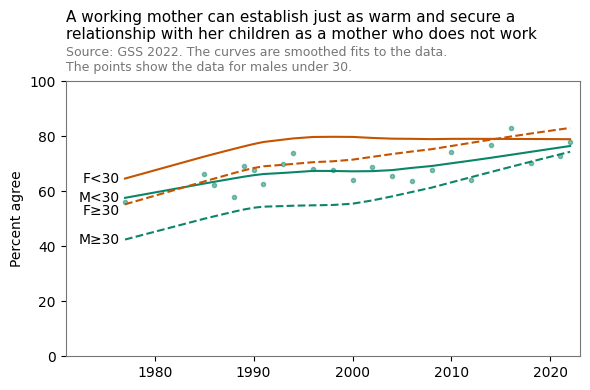

In [180]:
title = """A working mother can establish just as warm and secure a
relationship with her children as a mother who does not work"""
plot_four_series_weighted('fechld', title)
None

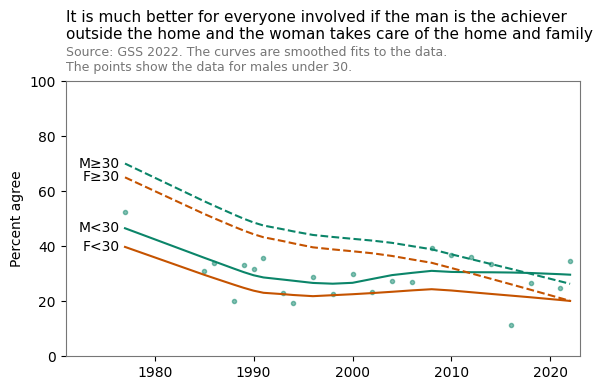

In [181]:
title = """It is much better for everyone involved if the man is the achiever 
outside the home and the woman takes care of the home and family"""
plot_four_series_weighted('fefam', title)

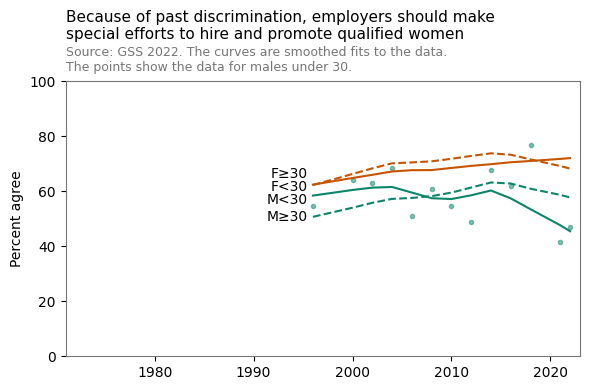

In [182]:
title = """Because of past discrimination, employers should make 
special efforts to hire and promote qualified women"""
plot_four_series_weighted('fehire', title)

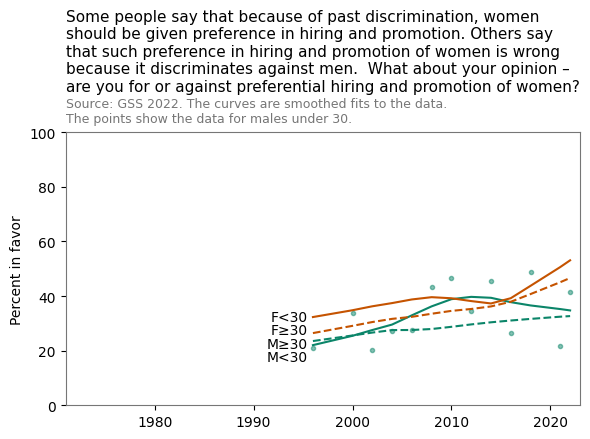

In [183]:
plt.figure(figsize=(6, 4.5))
title = """Some people say that because of past discrimination, women 
should be given preference in hiring and promotion. Others say 
that such preference in hiring and promotion of women is wrong 
because it discriminates against men.  What about your opinion – 
are you for or against preferential hiring and promotion of women?"""
plot_four_series_weighted('fejobaff', title)
plt.ylabel('Percent in favor');

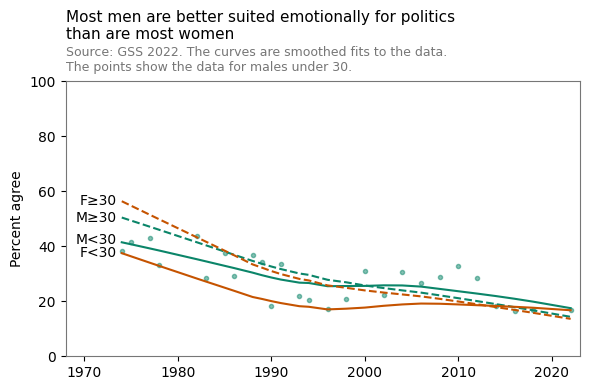

In [177]:
title = """Most men are better suited emotionally for politics
than are most women"""
plot_four_series_weighted('fepol', title)

plt.xlim([1968, 2023]);

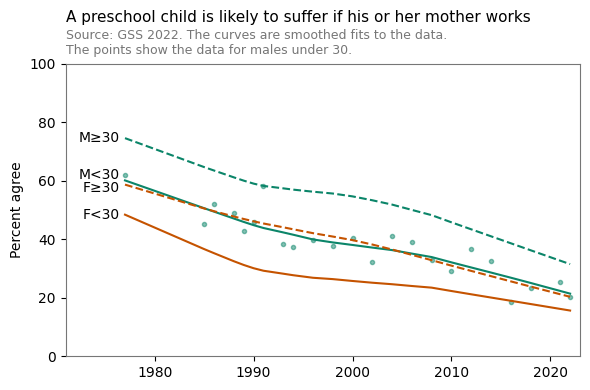

In [178]:
title = """A preschool child is likely to suffer if his or her mother works"""
plot_four_series_weighted('fepresch', title)

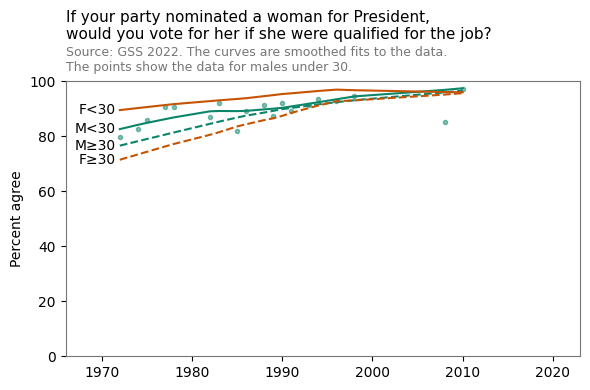

In [164]:
title = """If your party nominated a woman for President,
would you vote for her if she were qualified for the job?"""

plot_four_series_weighted('fepres', title)
plt.xlim(1966, 2023);

## Retired questions

In [12]:
retired_columns = ['fehelp', 'fehome', 'fework']

In [13]:
for column in retired_columns:
    query = 'year == 1998'
    series = make_series_weighted(gss, query, column)
    print(series[1998].round())

19.0
15.0
82.0


## Plot without smoothing

In [14]:
adjust_map = {('fejobaff', 'M<30'): -1.3,
              ('fejobaff', 'M≥30'): -0.3,
              ('fepol', 'F≥30'): 1,
             ('fehire', 'F≥30'): -0.5,
             }

smooth = False

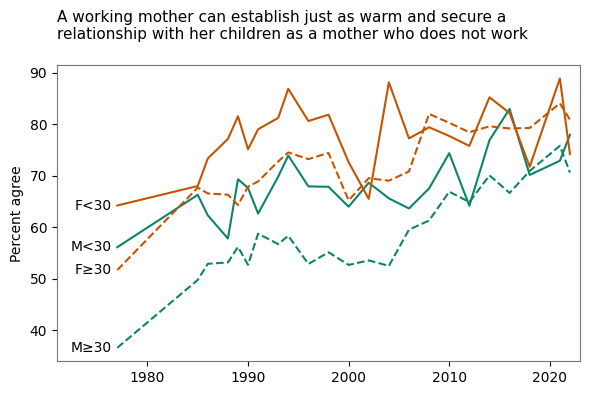

In [15]:
title = """A working mother can establish just as warm and secure a
relationship with her children as a mother who does not work
"""
plot_four_series_weighted('fechld', smooth=smooth)
plt.title(title, loc='left');

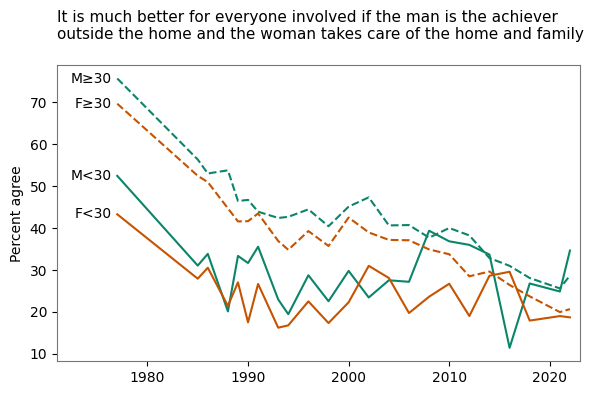

In [16]:
title = """It is much better for everyone involved if the man is the achiever 
outside the home and the woman takes care of the home and family
"""
plot_four_series_weighted('fefam', smooth=smooth)
plt.title(title, loc='left');

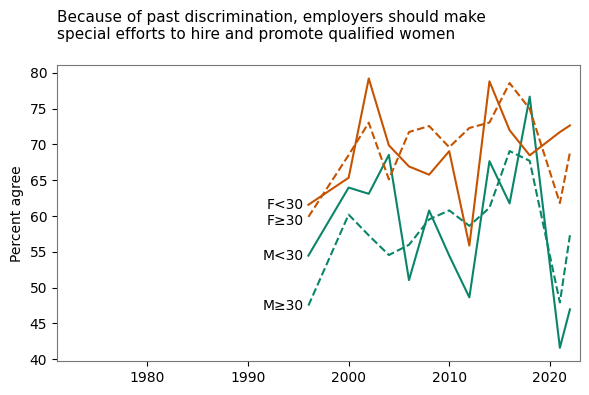

In [17]:
title = """Because of past discrimination, employers should make 
special efforts to hire and promote qualified women
"""
plot_four_series_weighted('fehire', smooth=smooth)
plt.title(title, loc='left');

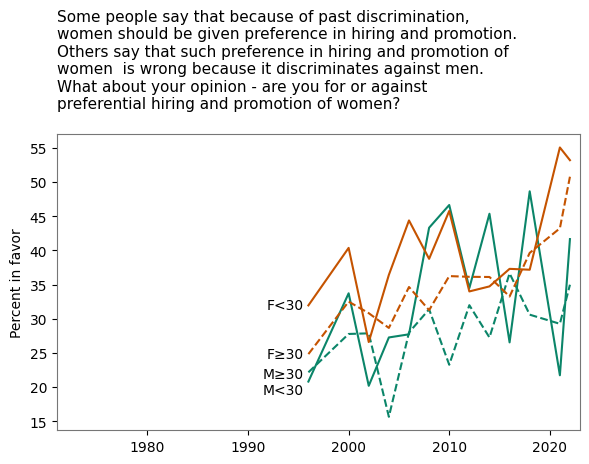

In [18]:
title = """Some people say that because of past discrimination, 
women should be given preference in hiring and promotion. 
Others say that such preference in hiring and promotion of 
women  is wrong because it discriminates against men. 
What about your opinion - are you for or against 
preferential hiring and promotion of women?
"""
plot_four_series_weighted('fejobaff', smooth=smooth)
plt.title(title, loc='left')
plt.ylabel('Percent in favor');

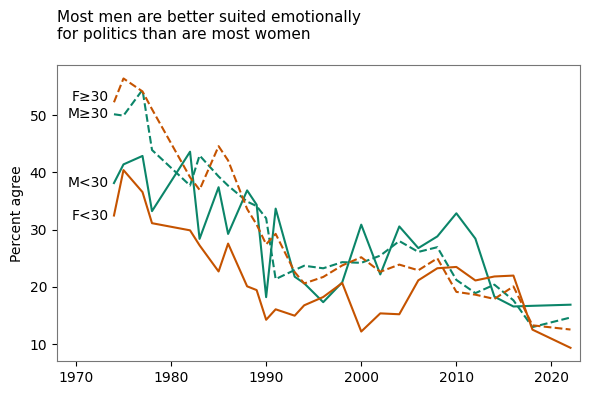

In [19]:
title = """Most men are better suited emotionally
for politics than are most women
"""
plot_four_series_weighted('fepol', smooth=smooth)
plt.title(title, loc='left')
plt.xlim([1968, 2023]);

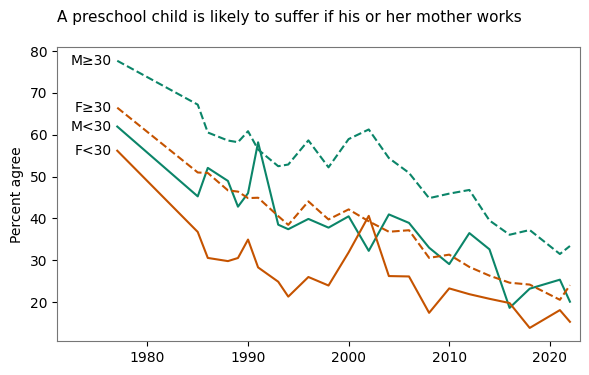

In [20]:
title = """A preschool child is likely to suffer if his or her mother works
"""
plot_four_series_weighted('fepresch', smooth=smooth)
plt.title(title, loc='left');